# Visualization

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

plt.style.use("dark_background")

In [35]:
def get_alpha_blend_cmap(cmap, alpha):
    cls = plt.get_cmap(cmap)(np.linspace(0,1,256))
    cls = (1-alpha) + alpha*cls
    return ListedColormap(cls)

def get_plot_kws(scatter_kws, line_kws):
    return {'line_kws':{'color':line_kws}, 'scatter_kws': {'color': scatter_kws}}

### Read Data

In [36]:
listings_df = pd.read_csv('../data/processed/processed_listings.csv')

In [37]:
listings_df.head()

,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_year,age,yard_area,listing_date,year_of_construction,price
0,2 Storey,2 storey,1191,4076,3,1,2,Capitale-Nationale,2020,16,2885,2020-12-01,2004,332500
1,Bungalow,Open area,1261,9500,2,1,1,Mauricie,2021,64,8239,2021-12-01,1957,265000
2,Townhouse,Unknown,1645,1360,3,1,3,Lachine,2021,15,0,2021-11-01,2006,612000
3,Bi-generation,Link,2024,17000,4,3,1,Capitale-Nationale,2021,2,14976,2021-12-01,2019,526500
4,Semi-detached,2 storey,2400,4471,4,2,2,Outaouais,2021,32,2071,2021-12-01,1989,360000


### Price

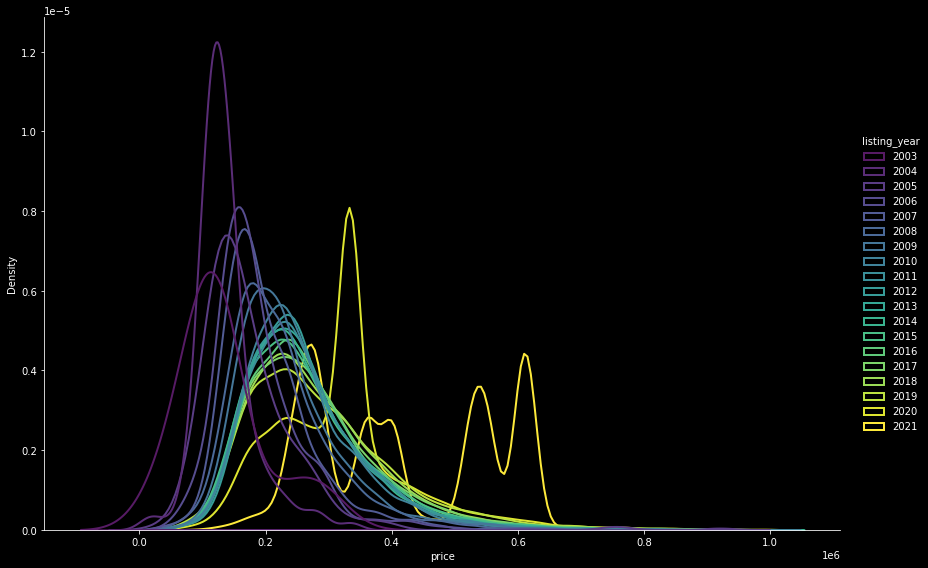

In [38]:
sns.displot(listings_df, x='price', hue='listing_year', kind="kde", fill=True, common_norm=False, height=8, aspect=1.5, alpha=.0, linewidth=2, palette=get_alpha_blend_cmap("viridis", 0.9))

### Listing Year

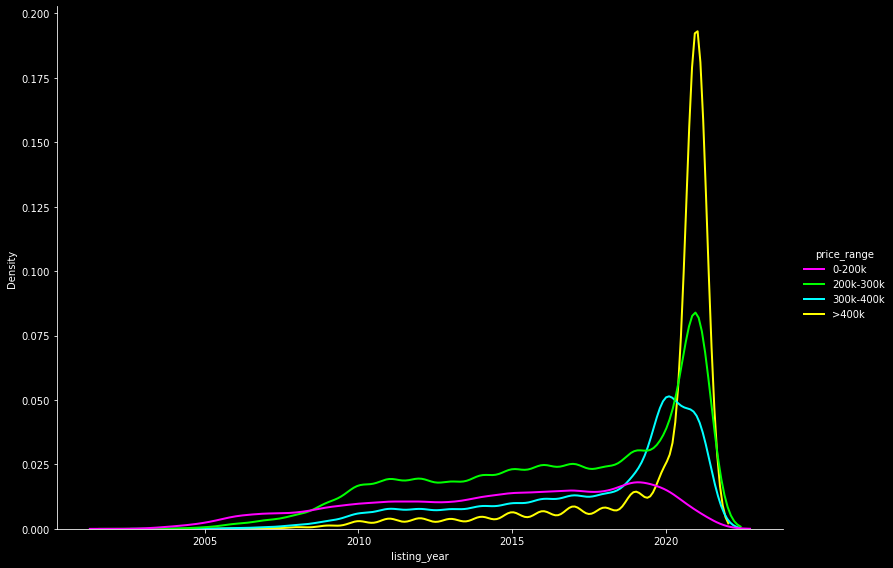

In [71]:
conditions = [(listings_df['price'] >= 0) & (listings_df['price'] < 200000), (listings_df['price'] >= 200000) & (listings_df['price'] < 300000), (listings_df['price'] >= 300000) & (listings_df['price'] < 400000), listings_df['price'] >= 400000]
values = ['0-200k', '200k-300k', '300k-400k', '>400k']

listings_df['price_range'] = np.select(conditions, values, default=0)
listings_df.head()
sns.displot(listings_df, x='listing_year', hue='price_range', hue_order=values, kind="kde", common_norm=True, height=8, aspect=1.4, linewidth=2, palette=['fuchsia', 'lime', 'aqua', 'yellow'])

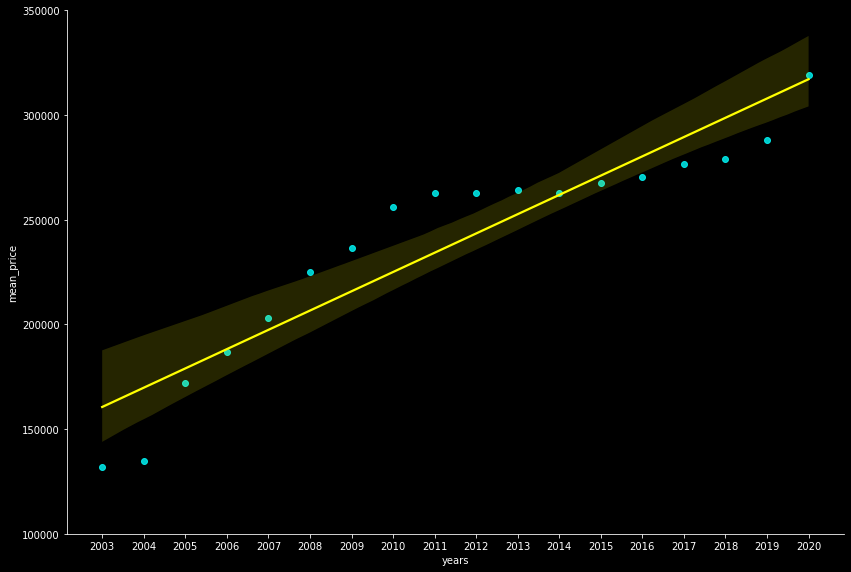

In [ ]:
mean_prices = []

min_y = min(listings_df['listing_year'].unique())
max_y = max(listings_df['listing_year'].unique())
years = range(min_y, max_y)

for y in years:
    mean_prices.append(listings_df[listings_df['listing_year'] == y]['price'].mean())

df = pd.DataFrame(list(zip(years, mean_prices)), columns =['years', 'mean_price'])

s = sns.pairplot(data=df, x_vars='years', y_vars='mean_price', kind="reg", height=8, aspect=1.5, plot_kws=get_plot_kws('cyan', 'yellow'))
s.set(xticks=years, yticks=range(100000, 400000, 50000))